In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy

## Load data to fit "ground truth" curves

In [2]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [3]:
def func(x, a, b):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*(x)**b

In [4]:
params = []
cycle_lives = []
true_gammas = []
#pred_cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    def parameter_estimation_function(x):
        return np.asarray(Y) - func(x=np.arange(1,len(Y)+1), a=x[0],b=x[1])- Y[0]
    
    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)


    alpha = param.x[0]
    beta = param.x[1]
    params.append([alpha,beta])

    cycle_lives.append(bat["cycle_life"][0])
#     true_cycle_lives.append(bat["cycle_life"][0])
#     fit_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-Y[0]),1/beta)])
    true_gammas.append([Y[0]])
params = np.array(params)
print(params)
cycle_lives = np.array(cycle_lives)
true_gammas = np.array(true_gammas)
#pred_cycle_lives = np.array(pred_cycle_lives)

[[-22.34157226   2.72843734]
 [-23.44714096   2.81433048]
 [-21.81744512   2.58716808]
 [-30.44004059   3.95616028]
 [-26.32505466   3.29915132]
 [-32.18695253   4.34750973]
 [-32.68052526   4.78454696]
 [-30.70008848   4.29107626]
 [-32.6356048    4.4380564 ]
 [-37.00976001   5.2763026 ]
 [-34.41204846   4.82090878]
 [-40.27353059   5.85385281]
 [-39.7268115    5.62837959]
 [-38.16339481   5.3951402 ]
 [-21.87439122   3.05265367]
 [-28.27814549   3.98772784]
 [-12.37120587   1.67389494]
 [-16.63154425   2.33298798]
 [-32.19602937   4.39739444]
 [-30.38087842   4.13083271]
 [-30.39349183   4.24611569]
 [-32.02930849   4.48273857]
 [-33.02885955   4.64415684]
 [-31.0236791    4.33974683]
 [-30.33047301   4.19427682]
 [-35.99807098   5.22443924]
 [-32.62514144   4.57051969]
 [-32.11768311   4.61300506]
 [-30.64875666   4.37727936]
 [-38.22109969   5.52213179]
 [-35.54881985   5.16003346]
 [-33.62420659   4.87010035]
 [-32.44486064   4.74386526]
 [-35.47528024   5.25493043]
 [-35.12569248

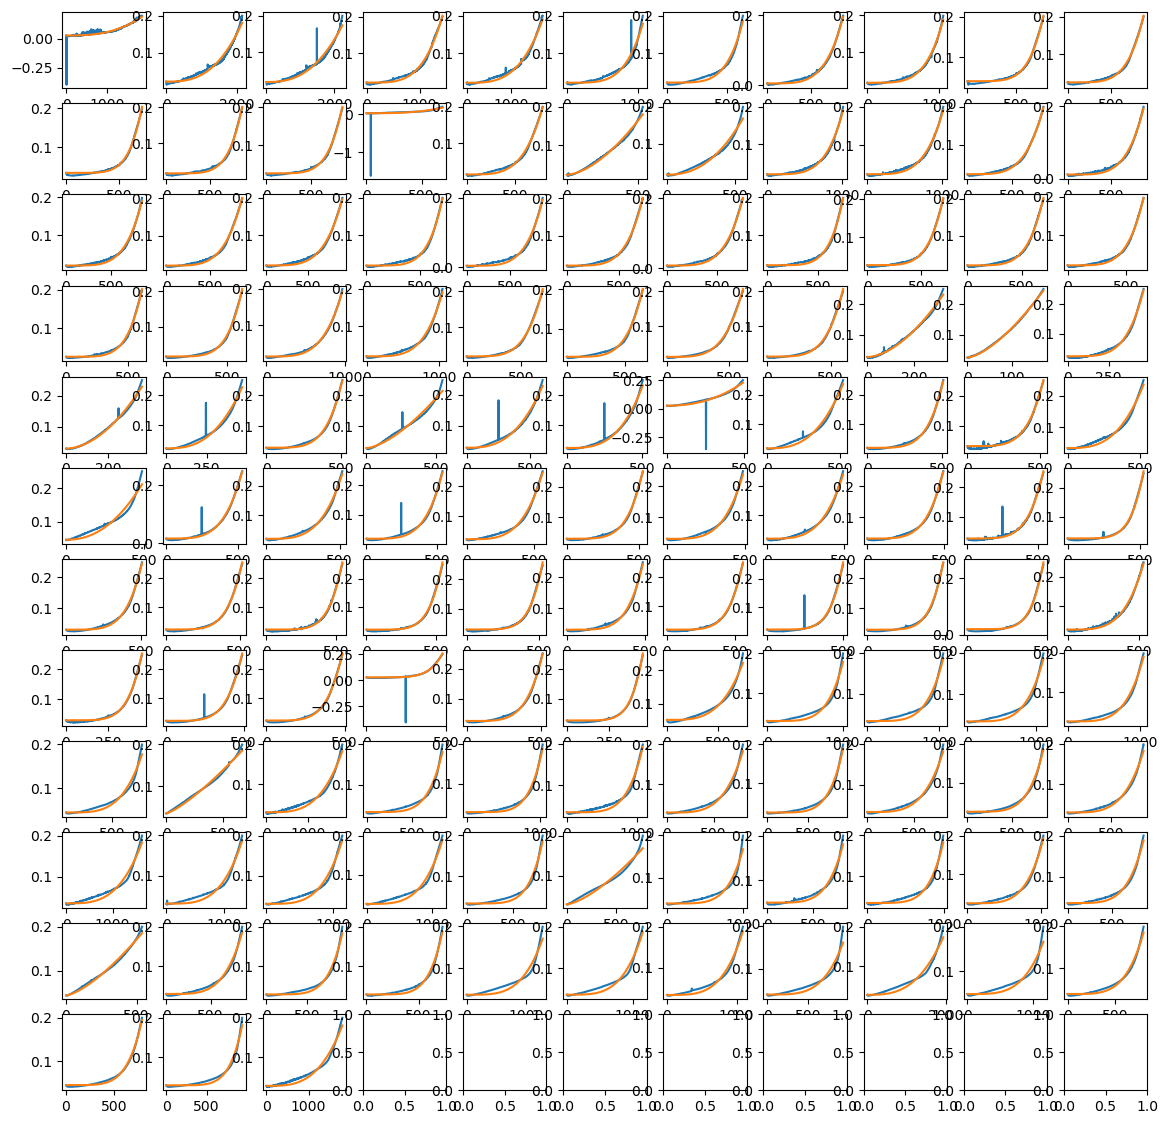

In [5]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    ax.plot(x, func(x,alpha,beta) + Y[0], linestyle="-")

In [6]:
def analytic_cycle_life(params, Y):
    a, b = params
    return np.power(np.exp(-a)*(0.2-Y[0]),1/b)

def counting_cycle_life(params, Y):
    a, b = params
    x = np.arange(1, 2500)
    curve = np.exp(a)*np.power(x, b) + Y[0]
    return np.sum(curve < 0.2)

b1c0	1893.4071672133182	1893	1852.0
b1c1	2246.5541637379597	2246	2160.0
b1c2	2377.655159646054	2377	2237.0
b1c3	1426.6429111449418	1426	1434.0
b1c4	1737.5112704115618	1737	1709.0
b1c5	1104.2467999617259	1104	1074.0
b1c6	645.3107302595217	645	636.0
b1c7	873.7069056214978	873	870.0
b1c9	1067.191974393237	1067	1054.0
b1c11	784.1542530100772	784	788.0
b1c14	875.5743739246275	875	880.0
b1c15	714.5689902470316	714	719.0
b1c16	859.5872563723877	859	862.0
b1c17	854.2011181990766	854	857.0
b1c18	723.2653931189296	723	691.0
b1c19	788.495389904949	788	788.0
b1c20	572.3828652101561	572	534.0
b1c21	603.8588668017433	603	559.0
b1c23	1025.7074904888511	1025	1014.0
b1c24	1027.8936213101913	1027	1017.0
b1c25	854.7322194558606	854	854.0
b1c26	874.0302418538392	874	870.0
b1c27	848.7919808909788	848	842.0
b1c28	856.8803036862445	856	860.0
b1c29	919.9292337470464	919	917.0
b1c30	709.0239880789981	709	709.0
b1c31	880.6294196700961	880	876.0
b1c32	728.1526205637421	728	731.0
b1c33	754.5853033771139	754	757.0

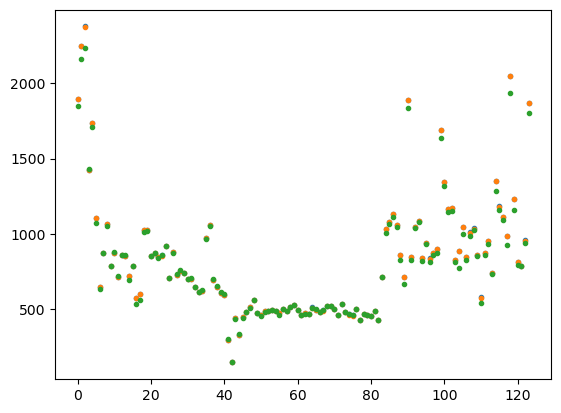

In [7]:
cls1 = []
cls2 = []
cls_true = []
for ix,id in enumerate(bat_dict.keys()):
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    cl1 = analytic_cycle_life(params[ix], Y)
    cl2 = counting_cycle_life(params[ix], Y)
    cl_true = bat_dict[id]["cycle_life"].item()
    print(id, cl1, cl2, cl_true, sep = "\t")
    for cl, list in zip([cl1, cl2, cl_true], [cls1, cls2, cls_true]):
        list.append(cl)
plt.plot(cls1, ".")
plt.plot(cls2, ".")
plt.plot(cls_true, ".")
print(np.mean(np.array(cls1) - np.array(cls2)))
print(np.mean(np.array(cls1) - np.array(cls_true)))

## Load data for predictive model

In [12]:
# features4 uses Severson interpolated data AND takes the log of all statistical features
# can try features3, which still uses Severson data but without the log of min, mean, skew kurtosis
data = np.loadtxt('./../Data/features5.csv',delimiter=',',skiprows=1) # skip row for column names

In [13]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [14]:
# logVar, logMean, logMin, logSkew, logKurtosis
x_train = data[:,[1,2,3]][train_ind]
y_train = params[train_ind]
life_train = cycle_lives[train_ind]
true_gammas_train = true_gammas[train_ind]

x_test = data[:,[1,2,3]][test_ind]
y_test = params[test_ind]
life_test = cycle_lives[test_ind]
true_gammas_test = true_gammas[test_ind]

x_stest = data[:,[1,2,3]][secondary_ind]
y_stest = params[secondary_ind]
life_stest = cycle_lives[secondary_ind]
true_gammas_stest = true_gammas[secondary_ind]

In [15]:
train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train), torch.Tensor(true_gammas_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test), torch.Tensor(true_gammas_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest), torch.Tensor(true_gammas_stest))

In [16]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [18]:
d_model = 2
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 1
nepoch = 1000
lr = 1e-3
batch_size = 1

In [19]:
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=2,attn_model=attn_model,skip_connect=skip_connect)
criterion = weighted_MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, _, true_gamma = batch
        output = model(train_input.to(device))
        
        loss = criterion(output, train_label, weights=torch.tensor([1/32,1/4]))
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, _, true_gamma = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(test_output, test_label, weights=torch.tensor([1/32,1/4]))

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, _, true_gamma = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(stest_output, stest_label, weights=torch.tensor([1/32,1/4]))
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 50 | rmse:  1.819 | rmse_test:  1.778 | rmse_stest:  1.764
Epochs: 100 | rmse:  1.070 | rmse_test:  1.101 | rmse_stest:  1.014
Epochs: 150 | rmse:  0.951 | rmse_test:  1.031 | rmse_stest:  0.966
Epochs: 200 | rmse:  0.946 | rmse_test:  1.035 | rmse_stest:  0.978
Epochs: 250 | rmse:  0.945 | rmse_test:  1.037 | rmse_stest:  0.980
Epochs: 300 | rmse:  0.944 | rmse_test:  1.038 | rmse_stest:  0.982
Epochs: 350 | rmse:  0.944 | rmse_test:  1.039 | rmse_stest:  0.982
Epochs: 400 | rmse:  0.944 | rmse_test:  1.039 | rmse_stest:  0.983
Epochs: 450 | rmse:  0.944 | rmse_test:  1.040 | rmse_stest:  0.985
Epochs: 500 | rmse:  0.943 | rmse_test:  1.040 | rmse_stest:  0.984
Epochs: 550 | rmse:  0.943 | rmse_test:  1.041 | rmse_stest:  0.985
Epochs: 600 | rmse:  0.943 | rmse_test:  1.041 | rmse_stest:  0.987
Epochs: 650 | rmse:  0.942 | rmse_test:  1.041 | rmse_stest:  0.985
Epochs: 700 | rmse:  0.943 | rmse_test:  1.041 | rmse_stest:  0.984
Epochs: 750 | rmse:  0.942 | rmse_test:  1.042 | 

163.80908168228632
200.74138853462583
254.56138971659524


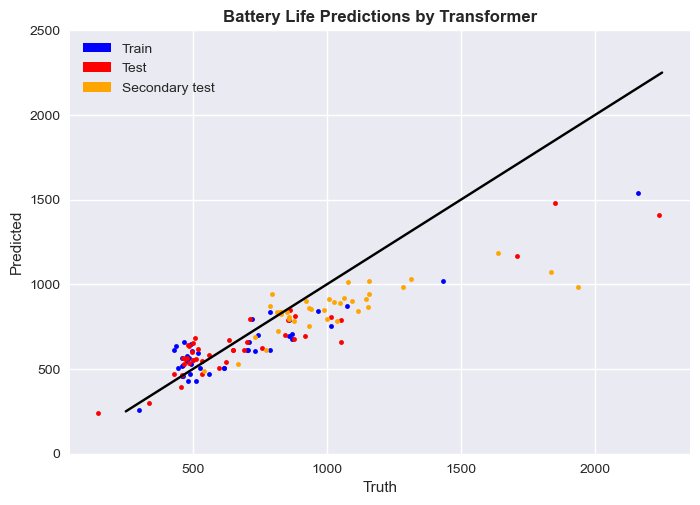

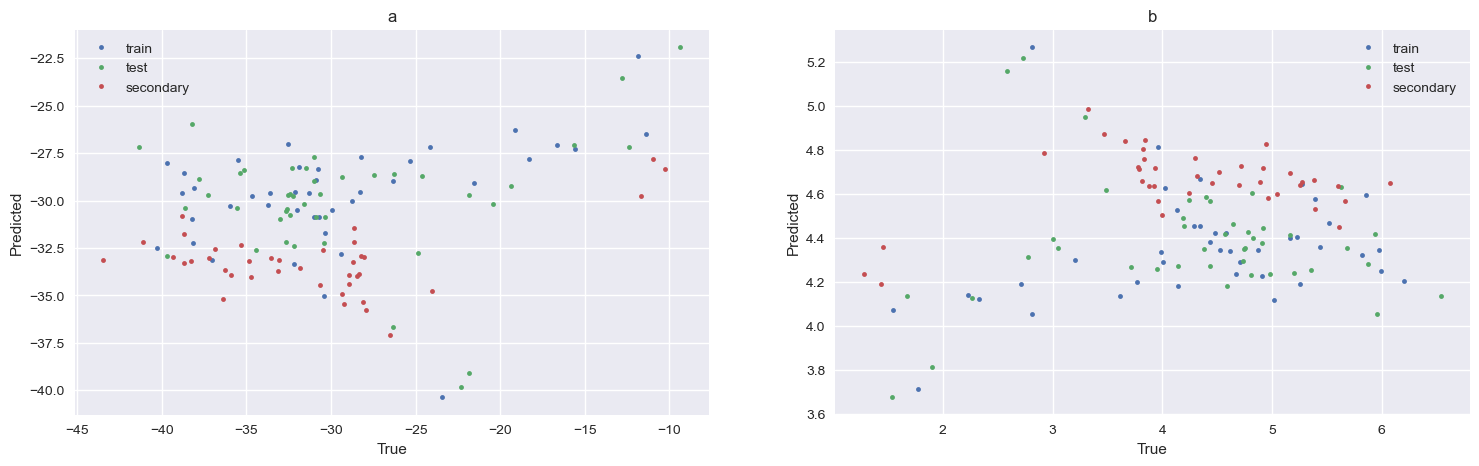

In [23]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life, true_gamma = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma[0]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 2)
for i, title in zip(range(2), ["a", "b"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

## Second round of training (calc loss w/ cycle lifetime)

In [50]:
# create a deep copy of model to fine tune
#model2 = copy.deepcopy(model)

In [24]:
# low learning rate and many epochs for fine-tuning
lr_fine = 1e-5
optimizer_fine = torch.optim.Adam(model.parameters(), lr=lr_fine)
nepoch = 2000
criterion = nn.MSELoss().to(device)
#criterion = weighted_MSELoss().to(device)

In [26]:
# Training loop

for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life, true_gamma = batch
        output = model(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-true_gamma[0]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life): 
            #print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life)
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life, true_gamma = cell
        test_output = model(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-true_gamma[0]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life, true_gamma = cell
        stest_output = model(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-true_gamma[0]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 100 | rmse:  121.044 | rmse_test:  142.751 | rmse_stest:  186.236
Epochs: 200 | rmse:  120.643 | rmse_test:  142.062 | rmse_stest:  185.858
Epochs: 300 | rmse:  120.069 | rmse_test:  141.545 | rmse_stest:  185.718
Epochs: 400 | rmse:  119.643 | rmse_test:  140.982 | rmse_stest:  185.415
Epochs: 500 | rmse:  119.288 | rmse_test:  140.491 | rmse_stest:  185.174
Epochs: 600 | rmse:  118.951 | rmse_test:  140.040 | rmse_stest:  184.948
Epochs: 700 | rmse:  118.662 | rmse_test:  139.689 | rmse_stest:  184.842
Epochs: 800 | rmse:  118.366 | rmse_test:  139.311 | rmse_stest:  184.635
Epochs: 900 | rmse:  118.090 | rmse_test:  138.958 | rmse_stest:  184.424
Epochs: 1000 | rmse:  117.863 | rmse_test:  138.650 | rmse_stest:  184.250
Epochs: 1100 | rmse:  117.667 | rmse_test:  138.392 | rmse_stest:  184.129
Epochs: 1200 | rmse:  117.479 | rmse_test:  138.156 | rmse_stest:  184.011
Epochs: 1300 | rmse:  117.329 | rmse_test:  137.953 | rmse_stest:  183.921
Epochs: 1400 | rmse:  117.200 | rm

In [ ]:
n = 100
x = torch.Tensor(np.arange(1,n))

plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
ix = 0

for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life, true_gamma = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-Y[0]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma

        # plot predicted vs. ground truth curves
        ax_curve = axs_curve[int(ix/11)][ix%11]
        ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
        ax_curve.plot(pred_curve, color="lightcoral")
        ix+=1

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

# plot predicted vs. actual cycle lives
ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

# plot predicted vs. ground truth model parameters
for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()